# Assignment 2

# Karunanayaka Y.S (190301H)

Github Repository: https://github.com/YSK-Machine-Vision-EN2550/Assignment_2.git

In [98]:
import numpy as np
from scipy . optimize import minimize
from scipy import linalg
import matplotlib . pyplot as plt
import cv2 as cv

In [2]:
N = 100
half_n = N // 2
r = 10
s = r /16
t = np . random . uniform (0 , 2*np . pi , half_n )
n = s*np . random . randn ( half_n )
x , y = ( r + n)*np . cos ( t ) , ( r + n)*np . sin ( t )
X_circ = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
m, b = -1, 2
x = np . linspace (-12, 12 , half_n )
y = m*x + b + s*np . random . randn ( half_n )
X_line = np . hstack ( ( x . reshape ( half_n , 1 ) , y . reshape ( half_n , 1 ) ) )
X = np . vstack ( ( X_circ , X_line ) )

In [3]:
# calculate the best fit circle
probability = 0.99
outlier_ratio = 0.40
trsh_dist = 0.9
s = 3
Itterations = int(np.log(1-probability)/np.log(1-(1-outlier_ratio)**s))

In [16]:
def RANSAC(X_circ, Itterations, trsh_dist):
    
    random_indexes = np.random.choice(range(X_circ.shape[0]), Itterations, replace=False)
    random_circles = []
    
    for i, _ in range(Itterations):
        # get three random points from the random samples
        r_points = [X_circ[j] for j in random_indexes]
        
        x, y = np.hsplit(np.array(r_points), 2)
        x, y = x.T[0], y.T[0]

        f = ((x[0]**2-x[1]**2+y[0]**2-y[1]**2)*(x[0]-x[2])-(x[0]**2-x[2]**2+y[0]**2-y[2]**2)*(x[0]-x[1]))/(2*((y[0]-y[2])*(x[0]-x[1])-(y[0]-y[1])*(x[0]-x[2])))
        g = ((x[0]**2-x[1]**2+y[0]**2-y[1]**2)*(y[0]-y[2])-(x[0]**2-x[2]**2+y[0]**2-y[2]**2)*(y[0]-y[1]))/(2*((y[0]-y[1])*(x[0]-x[2])-(y[0]-y[2])*(x[0]-x[1])))
        a, b, r = -g, -f, np.sqrt((x[0] + g)**2 + (y[0] + f)**2)
        
        random_circles.append((a,b,r))
        
    max_inliers = 0
    inliers = []
    circle = []
    
    for r_c in random_circles: # for each random circle
        counter = 0
        points = []
        for pt in r_points: # for each random point
            del_dist = abs(np.sqrt((pt[0] - r_c[0])**2 + (pt[1] - r_c[1])**2) - r)
            if del_dist < trsh_dist:
                counter += 1
                points.append(pt)
        if counter > max_inliers:
            max_inliers = counter
            inliers = points
            circle = r_c
            
    return circle, np.array(inliers)
                
        
while True:
    try:
        circle1, inliers1 = RANSAC(X_circ, Itterations, trsh_dist)
        circle2, inliers2 = RANSAC(inliers1, Itterations, trsh_dist)
        break
    except ValueError:
        pass

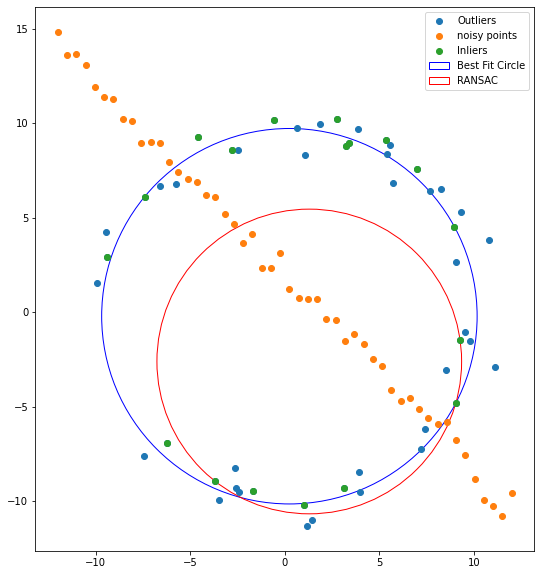

In [17]:
figure, axes = plt.subplots(figsize = (10,10))
axes.plot(X_circ[:,0],X_circ[:,1],'o',label = 'Outliers')
axes.plot(X_line[:,0],X_line[:,1],'o',label = 'noisy points')
axes.plot(inliers1[:,0], inliers1[:, 1], 'o',label = 'Inliers')

circle_1 = plt.Circle((circle1[0], circle1[1]),circle1[2],fill = False,color = 'blue',label = 'Best Fit Circle')
circle_2 = plt.Circle((circle2[0], circle2[1]),circle2[2],fill = False,color = 'red',label = 'RANSAC')

axes.set_aspect(1)
axes.add_artist(circle_1)
axes.set_aspect( 1 )
axes.add_artist(circle_2)

plt.legend()

plt.show()

## Question 2

In [99]:
imgPoints = []
def mousePoint(event, x,y,flags,params):
    if event == cv.EVENT_LBUTTONDOWN:
        imgPoints.append([x,y,1])

In [100]:
hall = cv.imread("003.jpg")
UK = cv.imread("UK.png")
cv.imshow('ImageWindow', hall)
cv.setMouseCallback('ImageWindow',mousePoint)
cv.waitKey()

-1

In [101]:
XT = [[0, 0, 1], [UK.shape[1] - 1, 0, 1], [UK.shape[1] - 1, UK.shape[0] - 1, 1], [0, UK.shape[0] - 1, 1]]
OT = [0,0,0]

IP = np.array(imgPoints, dtype = np.int16)
XT = np.array(XT, dtype = np.int16)
OT = np.array(OT, dtype = np.int16)

In [117]:
IP

array([[189, 308,   1],
       [594, 344,   1],
       [604, 565,   1],
       [181, 569,   1]], dtype=int16)

In [131]:
A = np.array([np.concatenate((OT, OT, OT), axis = 0)])
for i in range(4):
    B = np.array(
        [
            np.concatenate((OT, XT[i], -IP[i][1] * XT[i]), axis = 0),
            np.concatenate((XT[i], OT, -IP[i][0] * XT[i]), axis = 0)
        ]
    )
    
    A = np.concatenate((A, B), axis = 0)
print(A)    
A = A[1:].astype(np.float64)

[[     0      0      0      0      0      0      0      0      0]
 [     0      0      0      0      0      1      0      0   -308]
 [     0      0      1      0      0      0      0      0   -189]
 [     0      0      0   1599      0      1 -25768      0   -344]
 [  1599      0      1      0      0      0 -32302      0   -594]
 [     0      0      0   1599    799      1  14069   7317   -565]
 [  1599    799      1      0      0      0  17244 -23844   -604]
 [     0      0      0      0    799      1      0   4121   -569]
 [     0    799      1      0      0      0      0 -13547   -181]]


In [119]:
C =  A.T @ A

In [120]:
W,V = np.linalg.eig(C)

In [121]:
H = V[:, np.where(W == np.min(W))[0][0]]
H = H.reshape(3,3)

In [124]:
 new_img = cv.warpPerspective(UK, H, (2000,2000))

In [125]:
cv.imshow("warped", new_img)
cv.waitKey()

-1

In [88]:
hall.shape[1::-1]

(1024, 768)

In [129]:
H1, ST = cv.findHomography(XT, IP, cv.RANSAC, 5.0 )

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\fundam.cpp:1027: error: (-215:Assertion failed) npoints >= 0 && (depth == CV_32S || depth == CV_32F || depth == CV_64F) in function 'cv::convertPointsFromHomogeneous'


In [130]:
XT

array([[   0,    0,    1],
       [1599,    0,    1],
       [1599,  799,    1],
       [   0,  799,    1]], dtype=int16)